In [1]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.0 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=37b01b930e14878e7e67886962f5946f65e69c4ba8ebbef0fbbbb7b15e30387c
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [6]:
from torch.utils.data import DataLoader
import math
from sentence_transformers import util
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CESoftmaxAccuracyEvaluator
from sentence_transformers import InputExample
from datetime import datetime
import os
import shutil
import gzip
import csv
import pandas as pd
from zipfile import ZipFile

In [3]:
nli_dataset_path = 'datasets/AllNLI.tsv.gz'

if not os.path.exists(nli_dataset_path):
  util.http_get('https://sbert.net/datasets/AllNLI.tsv.gz', nli_dataset_path)

  0%|          | 0.00/40.8M [00:00<?, ?B/s]

In [9]:
with gzip.open(nli_dataset_path,'rt',encoding='utf8') as fin:
  with open('allnli.tsv','wt') as f_out:
    shutil.copyfileobj(fin,f_out)


In [ ]:
# Open file as Dataframe

In [28]:
df = pd.read_csv(r'/content/allnli.tsv',sep='\t',encoding='utf8',on_bad_lines='skip')
df.head()

,split,dataset,filename,sentence1,sentence2,label
0,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,train,SNLI,snli_1.0_train,Children smiling and waving at camera,They are smiling at their parents,neutral
4,train,SNLI,snli_1.0_train,Children smiling and waving at camera,There are children present,entailment


In [29]:
df_train = df[df['split']=='train']
df_dev = df[df['split']=='dev']
df_test = df[df['split']=='test']

len(df_train),len(df_dev),len(df_test)

(940532, 19556, 19656)

In [30]:
# reset index
df_dev.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

df_dev.head(3)

,split,dataset,filename,sentence1,sentence2,label
0,dev,SNLI,snli_1.0_dev,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...,neutral
1,dev,SNLI,snli_1.0_dev,Two women are embracing while holding to go pa...,Two woman are holding packages.,entailment
2,dev,SNLI,snli_1.0_dev,Two women are embracing while holding to go pa...,The men are fighting outside a deli.,contradiction


In [31]:
label2int = {"contradiction":0,"entailment":1,"neutral":2}

In [34]:
# Train samples
train_samples = []
df_train['sentence1'] = df_train['sentence1'].astype('str')
df_train['sentence2'] = df_train['sentence2'].astype('str')
for i in range(len(df_train[:100000])):
  label_id = df_train.loc[i,'label']
  train_samples.append(InputExample(texts=[df_train.loc[i,'sentence1'],df_train.loc[i,'sentence2']],
                                    label = label2int[label_id]))
  
# Dev samples
dev_samples = []
df_dev['sentence1'] = df_dev['sentence1'].astype('str')
df_dev['sentence2'] = df_dev['sentence2'].astype('str')
for i in range(len(df_dev)):
  label_id = df_dev.loc[i,'label']
  dev_samples.append(InputExample(texts=[df_dev.loc[i,'sentence1'],df_dev.loc[i,'sentence2']],
                                    label = label2int[label_id]))
  
# Test samples
test_samples = []
df_test['sentence1'] = df_test['sentence1'].astype('str')
df_test['sentence2'] = df_test['sentence2'].astype('str')
for i in range(len(df_test)):
  label_id = df_test.loc[i,'label']
  test_samples.append(InputExample(texts=[df_test.loc[i,'sentence1'],df_test.loc[i,'sentence2']],
                                    label = label2int[label_id]))

<ipython-input-34-7b3ee9d3de6f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['sentence1'] = df_train['sentence1'].astype('str')
<ipython-input-34-7b3ee9d3de6f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['sentence2'] = df_train['sentence2'].astype('str')
<ipython-input-34-7b3ee9d3de6f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [4]:
label2int = {"contradiction":0,"entailment":1,"neutral":2}

train_samples = []
dev_samples = []

with gzip.open(nli_dataset_path,'rt',encoding='utf8') as f:
  reader = csv.DictReader(f,delimiter='\t',quoting=csv.QUOTE_NONE)
  for row in reader:
    label_id = label2int[row['label']]
    if row['split'] == 'train':
      train_samples.append(InputExample(texts=[row['sentence1'],row['sentence2']],
                                        label=label_id))
    else:
      dev_samples.append(InputExample(texts=[row['sentence1'],row['sentence2']],
                                      label=label_id))

In [35]:
train_batch_size =16
num_epochs = 4
model_save_path = 'output/training_allnli-'+datetime.now().strftime("%Y-%m-%d")

# Define Cross Encoder model
model = CrossEncoder('distilroberta-base',num_labels=len(label2int))

# We wrap train_samples, which is a list ot InputExample, in a pytorch DataLoader
train_dataloader = DataLoader(train_samples,
                              shuffle=True,
                              batch_size=train_batch_size)

#During training, we use CESoftmaxAccuracyEvaluator to measure the accuracy on the dev set.
evaluator = CESoftmaxAccuracyEvaluator.from_input_examples(dev_samples,
                                                           name='AllNLI-dev')

warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up

# Train the model
model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=10000,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.weight'

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6250 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6250 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6250 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6250 [00:00<?, ?it/s]

In [36]:
##### Load model and eval on test set
model = CrossEncoder(model_save_path)

evaluator = CESoftmaxAccuracyEvaluator.from_input_examples(test_samples,name='Quora-test')
evaluator(model)

0.7897842897842898

In [37]:
test = []
for i in range(len(df_test)):
  test.append([df_test.loc[i,'sentence1'],df_test.loc[i,'sentence2']])

predictions = model.predict(test,show_progress_bar=True)
predictions

Batches:   0%|          | 0/615 [00:00<?, ?it/s]

array([[ 4.3395033 , -3.4922066 , -0.48483604],
       [-3.1601024 ,  3.2703142 , -0.5011486 ],
       [ 3.93533   , -3.706817  ,  0.55907637],
       ...,
       [ 4.745167  , -2.501305  , -1.7712649 ],
       [-3.412799  ,  1.8171378 ,  1.3431523 ],
       [-2.3984313 ,  2.1989956 ,  0.22584805]], dtype=float32)

In [44]:
import numpy as np
pred = np.argmax(predictions,axis=1)
pred

array([0, 1, 0, ..., 0, 1, 1])

In [45]:
pred = pred.tolist()

In [46]:
df_test['pred_label'] = pred
df_test.head()

<ipython-input-46-9c1f0b43fe8d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_label'] = pred


,split,dataset,filename,sentence1,sentence2,label,pred_label
0,test,SNLI,snli_1.0_test,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,neutral,0
1,test,SNLI,snli_1.0_test,This church choir sings to the masses as they ...,The church is filled with song.,entailment,1
2,test,SNLI,snli_1.0_test,This church choir sings to the masses as they ...,A choir singing at a baseball game.,contradiction,0
3,test,SNLI,snli_1.0_test,"A woman with a green headscarf, blue shirt and...",The woman is young.,neutral,2
4,test,SNLI,snli_1.0_test,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,entailment,1


In [47]:
y = [label2int[l] for l in df_test['label'].values]
y[:5]

[2, 1, 0, 2, 1]

In [48]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
print('Accuracy Score:',accuracy_score(y,pred))
print()
print('Classification Report')
print(classification_report(y,pred))

Accuracy Score: 0.7897842897842898

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      6477
           1       0.81      0.83      0.82      6831
           2       0.74      0.74      0.74      6348

    accuracy                           0.79     19656
   macro avg       0.79      0.79      0.79     19656
weighted avg       0.79      0.79      0.79     19656



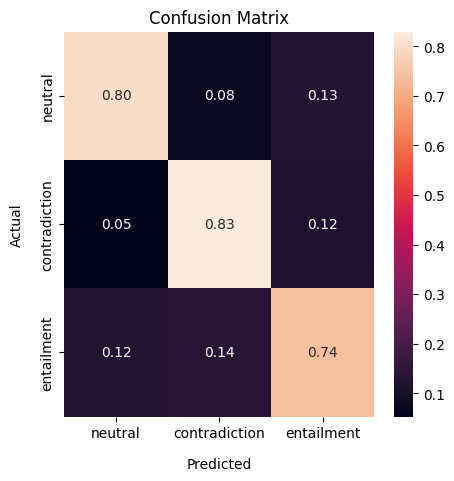

In [62]:
# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y,pred,normalize='true')
labels = list(set(df_test['label'].values))
df_cm = pd.DataFrame(cm,index=labels,columns=labels)
fig = plt.figure(figsize = (5,5))
ax = sns.heatmap(df_cm,annot=True,fmt='.2f')
ax.set_xlabel('Predicted',labelpad=12)
ax.set_ylabel('Actual',labelpad=12)
ax.set_title('Confusion Matrix')
plt.show() 